In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.vectors import FloatVector, IntVector, ListVector, Vector, StrVector
from rpy2.robjects import DataFrame, IntVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [453]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/combined_other_datasets_for_modeling.csv')
df = dfs.copy()

print(df.shape)
print()
print(df.info())
print()
df.head(3)


(1678, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB
None



,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [454]:
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Study_id: {'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}


In [455]:
df = df[df['Expt'] != 'riluzole']
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

df.shape

Expt: {'mirocals': 220, 'licals': 176}

Study_id: {'miro': 220, 'lica': 176}


(396, 13)

In [456]:
df['Ages'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['TRICALSs'] = (df['TRICALS'] - df['TRICALS'].mean()) / df['TRICALS'].std()

df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109


In [457]:
df_time_var = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time_var.describe()
# df_time.isna().sum()

,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,396.000000,396.000000,396.000000
mean,29.773236,12.600114,93.606061
std,8.569203,5.929346,17.016042
min,8.051348,0.984000,60.000000
25%,24.530716,7.923000,80.000000
50%,31.473046,12.481527,92.000000
75%,36.177070,16.962729,104.000000
max,50.636005,31.767411,139.000000


In [458]:
df['Disease_Durationl'] = np.log1p(df['Disease_Duration']) # ln(1 + x)
df['Diagnostic_Delayl'] = np.log1p(df['Diagnostic_Delay']) # ln(1 + x)
df['Vital_capacityl'] = np.log(df['Vital_capacity']) # ln(x)

df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973


In [459]:
df['Disease_Durationls'] = (df['Disease_Durationl'] - df['Disease_Durationl'].mean()) / df['Disease_Durationl'].std()
df['Diagnostic_Delayls'] = (df['Diagnostic_Delayl'] - df['Diagnostic_Delayl'].mean()) / df['Diagnostic_Delayl'].std()
df['Vital_capacityls'] = (df['Vital_capacityl'] - df['Vital_capacityl'].mean()) / df['Vital_capacityl'].std()

df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421


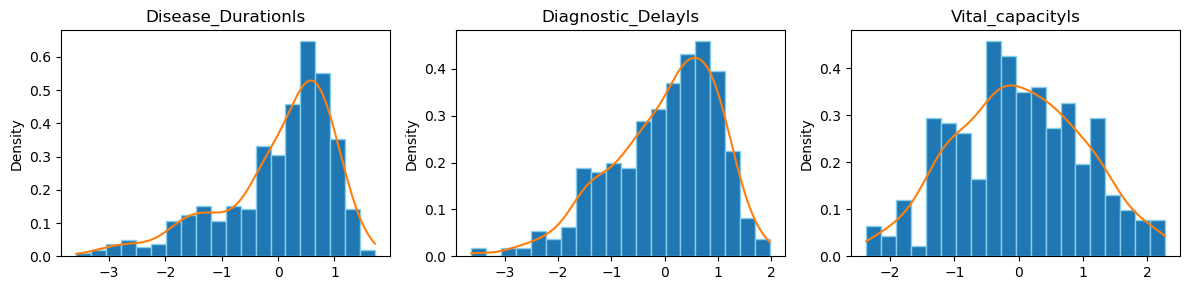

In [460]:
df_time = df[['Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls']]
df_time.describe()

# Plot histogram and density
cols = df_time.columns
n_per_row = 3
n_rows = int(np.ceil(len(cols) / n_per_row))


fig, axes = plt.subplots(
    n_rows, n_per_row,
    figsize=(4 * n_per_row, 3 * n_rows)
)

axes = axes.flatten()

for ax, col in zip(axes, cols):
    data = df_time[col].dropna()

    ax.hist(data, bins=20, density=True, edgecolor='skyblue')

    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 300)
    ax.plot(x, kde(x))

    ax.set_title(col)
    ax.set_ylabel('Density')

for ax in axes[len(cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



In [461]:
df['European'] = df['European'].astype('int')
df['Event'] = df['Event'].astype('int')

In [462]:
print(f'Event: {df['Event'].value_counts().to_dict()}\n')
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Event: {0: 240, 1: 156}

Expt: {'mirocals': 220, 'licals': 176}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 392, 0: 4}



In [463]:
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar', 'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 0, 'Non-European', 'European')

In [464]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'mirocals': 220, 'licals': 176}

Onset_site: {'Limb': 319, 'Bulbar': 77}

Sex: {'Male': 262, 'Female': 134}

Study_Arm: {'Active': 199, 'Placebo': 197}

European: {'European': 392, 'Non-European': 4}



In [465]:
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls
0,P01001,0,107.0,Male,Limb,Placebo,European,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667
1,P01002,1,99.0,Female,Limb,Placebo,European,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582
2,P01003,0,102.0,Male,Limb,Active,European,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421


In [466]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex', 'Study_Arm','Expt']

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667,True,False,True,True,False
1,P01002,1,99.0,61.160849,20.137976,41.538765,-6.347018,lica,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582,True,False,False,True,False


In [467]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Ages', 'TRICALSs',
       'Disease_Durationl', 'Diagnostic_Delayl', 'Vital_capacityl',
       'Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls',
       'Onset_site_Limb', 'European_Non-European', 'Sex_Male',
       'Study_Arm_Placebo', 'Expt_mirocals'],
      dtype='object')

In [468]:
cols = ['Onset_site_Limb', 'European_Non-European', 'Sex_Male', 'Study_Arm_Placebo', 'Expt_mirocals']

# Convert one-hot encoded columns to int
for col in cols:
    df_onehot[col] = df_onehot[col].astype(int)

df_onehot.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667,1,0,1,1,0
1,P01002,1,99.0,61.160849,20.137976,41.538765,-6.347018,lica,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582,1,0,0,1,0
2,P01003,0,102.0,46.702259,15.571616,34.571616,-6.373852,lica,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421,1,0,1,0,0


In [469]:
# Create interactions
df_onehot['Sex_onset'] = df_onehot['Sex_Male']*df_onehot['Onset_site_Limb']
df_onehot['Age_Sex'] = df_onehot['Sex_Male']*df_onehot['Ages']
df_onehot['Age_onset'] = df_onehot['Ages']*df_onehot['Onset_site_Limb']
df_onehot['Age_TRICALS'] = df_onehot['Ages']*df_onehot['TRICALSs']
# df_onehot['Trical : Placebo Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

# df_onehot.info()
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667,1,0,1,1,0,1,-0.355001,-0.355001,0.026920
1,P01002,1,99.0,61.160849,20.137976,41.538765,-6.347018,lica,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582,1,0,0,1,0,0,0.000000,0.255274,-0.298299


In [470]:
df1 = df_onehot.copy()

In [471]:
df1.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Ages', 'TRICALSs',
       'Disease_Durationl', 'Diagnostic_Delayl', 'Vital_capacityl',
       'Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls',
       'Onset_site_Limb', 'European_Non-European', 'Sex_Male',
       'Study_Arm_Placebo', 'Expt_mirocals', 'Sex_onset', 'Age_Sex',
       'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [472]:
df1 = df1[['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id', 'Study_Arm_Placebo',
       'Ages', 'TRICALSs', 'Diagnostic_Delayls', 'Vital_capacityls', 'Onset_site_Limb', 'European_Non-European', 'Sex_Male',
       'Sex_onset', 'Age_Sex', 'Age_onset', 'Age_TRICALS']]

df1 = df1.rename(columns={'Ages': 'Age',
                        'Vital_capacityls': 'Vital_capacity',
                        'Diagnostic_Delayls': 'Diagnostic_Delay',
                        'TRICALSs': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb',
                        'Sex_1': 'Sex_Male'
                        })

df1.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id',
       'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'European_Yes', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [473]:
df1.head(3)

,subject_id,Event,Disease_Duration,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,European_Yes,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0,32.600526,0,lica,1,-0.355001,-0.075830,0.363265,0.828667,1,0,1,1,-0.355001,-0.355001,0.026920
1,P01002,1,41.538765,0,lica,1,0.255274,-1.168542,1.103061,0.399582,1,0,0,0,0.000000,0.255274,-0.298299
2,P01003,0,34.571616,0,lica,0,-1.123785,-1.189109,0.616453,0.564421,1,0,1,1,-1.123785,-1.123785,1.336303


In [474]:
# df1.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/processed_data_for_flexible_parametric_model.csv', index=False)

In [475]:
# Train / Test split
print(df1.shape)

# Separate features from survival info
X = df1.drop(columns=['Disease_Duration', 'Event'])
y_duration = df1['Disease_Duration']
y_event = df1['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.25, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

len(train_df), len(test_df)

(396, 17)


(297, 99)

In [476]:
with conversion.localconverter(pandas2ri.converter):
    r_df_train = pandas2ri.py2rpy(train_df)

with conversion.localconverter(pandas2ri.converter):
    r_df_test = pandas2ri.py2rpy(test_df)

# with conversion.localconverter(pandas2ri.converter):
#     r_df = pandas2ri.py2rpy(df1)

#### CV Backward stepwise selection based on AIC and spline df selection
<!-- ##### investigate the code further -->

In [477]:
# Candidate covariates (modify for your dataset)
covariates = [
   'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS','Expt_mirocals'
    ]

df_candidates = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [478]:
def cv_aic_for_model(df_python, vars_list, spline_df, n_splits=5):
    """
    Compute mean cross-validated AIC for a given variable set and spline df
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    aics = []

    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)

    for train_idx, test_idx in kf.split(df_python):
        train_df = df_python.iloc[train_idx]

        # Convert fold to R
        with localconverter(default_converter + pandas2ri.converter):
            r_train = pandas2ri.py2rpy(train_df)

        try:
            model = rstpm2.stpm2(formula, data=r_train, df=spline_df)
            aic = stats.AIC(model)[0]
            aics.append(aic)
        except Exception:
            aics.append(np.inf)

    return np.mean(aics)


In [479]:
n_splits = 5

current_vars = covariates.copy()
best_score = np.inf
best_vars = current_vars
best_df = None

while True:
    candidates = []

    # Try current model with different dfs
    for df_spline in df_candidates:
        score = cv_aic_for_model(train_df, current_vars, df_spline, n_splits)
        candidates.append((score, current_vars, df_spline))

    # Try removing each variable
    for var in current_vars:
        test_vars = [v for v in current_vars if v != var]
        for df_spline in df_candidates:
            score = cv_aic_for_model(train_df, test_vars, df_spline, n_splits)
            candidates.append((score, test_vars, df_spline))

    # Pick best candidate
    best_candidate = min(candidates, key=lambda x: x[0])

    cand_score, cand_vars, cand_df = best_candidate

    # Stop if no improvement
    if cand_score >= best_score:
        break

    best_score = cand_score
    best_vars = cand_vars
    best_df = cand_df
    current_vars = cand_vars

print("\n Selected model by CV-AIC:")
print("Variables:", best_vars)
print("Spline df:", best_df)
print("CV-AIC:", best_score)



 Selected model by CV-AIC:
Variables: ['Age', 'TRICALS', 'Onset_Limb', 'Sex_Male', 'Sex_onset', 'Expt_mirocals']
Spline df: 3
CV-AIC: 717.1084487725691


### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [480]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb  + Sex_onset + Expt_mirocals + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
print(ro.r.summary(fp_model))

Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(Disease_Duration, Event == 1) ~ Age + Sex_Male + 
    Onset_Limb + Sex_onset + Expt_mirocals + Diagnostic_Delay + 
    Study_Arm_Placebo, data = list(subject_id = c("1-62532", 
"1-63842", "P06011", "1-62647", "1-63258", "1-63446", "P05020", 
"1-63825", "P03006", "1-62625", "1-62569", "1-62575", "1-63441", 
"1-62523", "P05027", "P02013", "1-62486", "P10009", "1-62280", 
"1-63180", "P05017", "1-63256", "P07004", "1-63570", "1-63447", 
"1-62646", "1-63535", "P03007", "1-63501", "P09010", "1-63442", 
"P09012", "1-62546", "P06007", "P08007", "1-63539", "1-63257", 
"P10019", "1-63710", "1-62272", "P08006", "P01019", "P10011", 
"1-63843", "P05024", "1-62605", "1-62253", "P06009", "1-62566", 
"1-63847"

In [481]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Sex_onset + Expt_mirocals + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
print(ro.r.summary(fp_model))

Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(Disease_Duration, Event == 1) ~ Age + Sex_Male + 
    Onset_Limb + TRICALS + Sex_onset + Expt_mirocals + Diagnostic_Delay + 
    Study_Arm_Placebo, data = list(subject_id = c("1-62532", 
"1-63842", "P06011", "1-62647", "1-63258", "1-63446", "P05020", 
"1-63825", "P03006", "1-62625", "1-62569", "1-62575", "1-63441", 
"1-62523", "P05027", "P02013", "1-62486", "P10009", "1-62280", 
"1-63180", "P05017", "1-63256", "P07004", "1-63570", "1-63447", 
"1-62646", "1-63535", "P03007", "1-63501", "P09010", "1-63442", 
"P09012", "1-62546", "P06007", "P08007", "1-63539", "1-63257", 
"P10019", "1-63710", "1-62272", "P08006", "P01019", "P10011", 
"1-63843", "P05024", "1-62605", "1-62253", "P06009", "1-62566", 

            Variable  Estimate  Std. Error    z value         Pr(z)
0                Age -0.451557    0.125915  -3.586199  3.355328e-04
1           Sex_Male  0.789987    0.387467   2.038853  4.146470e-02
2         Onset_Limb  0.904501    0.320842   2.819149  4.815113e-03
3            TRICALS  3.192837    0.236680  13.490123  1.788012e-41
4          Sex_onset -1.107842    0.440333  -2.515917  1.187233e-02
5      Expt_mirocals -0.263275    0.232929  -1.130280  2.583584e-01
6   Diagnostic_Delay  0.173148    0.135621   1.276712  2.017038e-01
7  Study_Arm_Placebo  0.202307    0.184363   1.097334  2.724955e-01


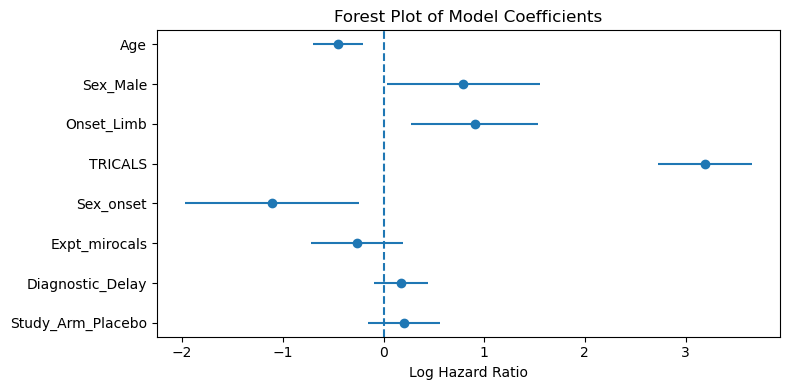

In [ ]:
# Get coefficients directly
summary = ro.r.summary(fp_model)

# Try using slotNames to see what's available
# print("Available slots:", ro.r.slotNames(summary))

# Extract using the correct slot name (usually 'coef' or 'coefficients')
coefficients = summary.slots['coef']

# Convert to pandas DataFrame
df_coef = pd.DataFrame(
    np.array(coefficients),
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
    index=list(coefficients.rownames)
)

df_coef = df_coef.iloc[1: -1]
df_coef = df_coef.reset_index().rename(columns={"index": "Variable"})


print(df_coef)

#--------------------------------------
z = 1.96  # 95% CI

df_coef["LHR"] = (df_coef["Estimate"])
df_coef["CI_lower"] = (df_coef["Estimate"] - z * df_coef["Std. Error"])
df_coef["CI_upper"] = (df_coef["Estimate"] + z * df_coef["Std. Error"])

#--------------------------------------
plt.figure(figsize=(8, 4))

ypos = np.arange(len(df_coef))

# Confidence intervals
plt.hlines(
    y=ypos,
    xmin=df_coef["CI_lower"],
    xmax=df_coef["CI_upper"]
)

# Point estimates
plt.plot(df_coef["Estimate"], ypos, "o")

# Vertical reference line at 0
plt.axvline(0, linestyle="--")

plt.yticks(ypos, df_coef["Variable"])
plt.xlabel("Log Hazard Ratio")
plt.title("Forest Plot of Model Coefficients")

plt.gca().invert_yaxis()  # top-to-bottom
plt.tight_layout()
plt.show()

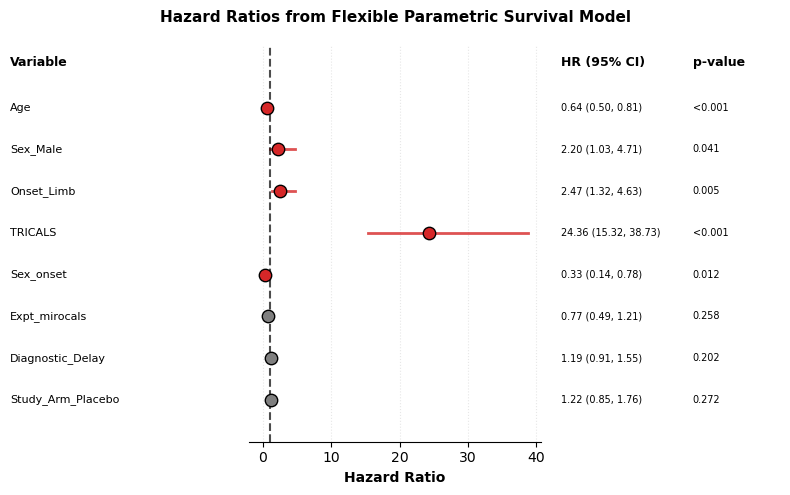

In [545]:
# Convert to hazard ratios
df_coef['HR'] = np.exp(df_coef['Estimate'])
df_coef['HR_lower'] = np.exp(df_coef['Estimate'] - 1.96 * df_coef['Std. Error'])
df_coef['HR_upper'] = np.exp(df_coef['Estimate'] + 1.96 * df_coef['Std. Error'])
df_coef['Significant'] = df_coef['Pr(z)'] < 0.05

# Create figure with subplots for labels and plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 5), 
                                      gridspec_kw={'width_ratios': [3, 4, 3]})

y_positions = np.arange(len(df_coef))

# Left panel - Variable names
ax1.axis('off')
ax1.text(0, len(df_coef), 'Variable', fontweight='bold', fontsize=9)
for idx, var in enumerate(df_coef['Variable']):
    ax1.text(0, len(df_coef) - idx - 1, var, fontsize=8, va='center')
ax1.set_ylim(-1, len(df_coef) + 0.5)

# Middle panel - Forest plot
for idx, row in df_coef.iterrows():
    y_pos = len(df_coef) - idx - 1
    color = '#d62728' if row['Significant'] else '#7f7f7f'
    
    # CI line
    ax2.plot([row['HR_lower'], row['HR_upper']], [y_pos, y_pos], 
            color=color, linewidth=2, alpha=0.8)
    
    # Point estimate
    ax2.scatter(row['HR'], y_pos, s=80, color=color, 
               zorder=3, edgecolors='black', linewidth=1)

# Reference line
ax2.axvline(x=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

ax2.set_xlabel('Hazard Ratio', fontsize=10, fontweight='bold')
ax2.set_yticks([])
ax2.set_ylim(-1, len(df_coef) + 0.5)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.8)
ax2.set_xlim(left=min(-2, df_coef['HR_lower'].min() - 0.5))

# Right panel - HR values and p-values
ax3.axis('off')
ax3.text(0, len(df_coef), 'HR (95% CI)', fontweight='bold', fontsize=9)
ax3.text(0.6, len(df_coef), 'p-value', fontweight='bold', fontsize=9)

for idx, row in df_coef.iterrows():
    y_pos = len(df_coef) - idx - 1
    hr_text = f"{row['HR']:.2f} ({row['HR_lower']:.2f}, {row['HR_upper']:.2f})"
    p_text = f"{row['Pr(z)']:.3f}" if row['Pr(z)'] >= 0.001 else "<0.001"
    
    ax3.text(0, y_pos, hr_text, fontsize=7, va='center')
    ax3.text(0.6, y_pos, p_text, fontsize=7, va='center')

ax3.set_ylim(-1, len(df_coef) + 0.5)

plt.suptitle('Hazard Ratios from Flexible Parametric Survival Model', 
             fontsize=11, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

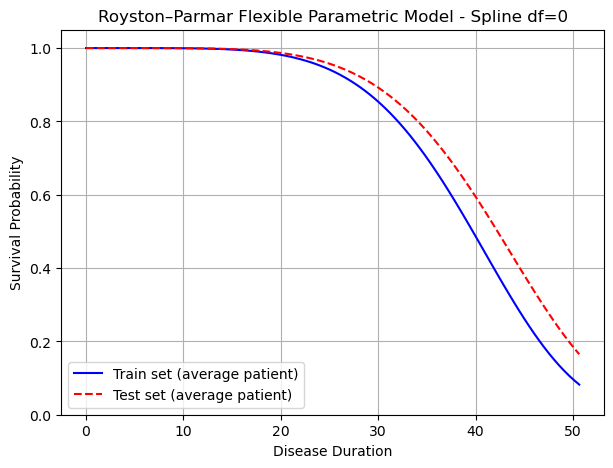

In [483]:
# Common time points for prediction
times = np.linspace(0, df1["Disease_Duration"].max(), 100)

# Helper to create newdata for prediction given a dataframe (train or test)
def make_newdata(df):
    mean_Age = df["Age"].mean()
    mean_TRICALS = df["TRICALS"].mean()
    mean_Vital = df["Vital_capacity"].mean()
    mean_Delay = df["Diagnostic_Delay"].mean()

    mode_Onset = df["Onset_Limb"].mode()[0]
    mode_Sex_Male = df["Sex_Male"].mode()[0]
    mode_Sex_onset = df["Sex_onset"].mode()[0]
    mode_Expt = df["Expt_mirocals"].mode()[0]
    mode_Study_Arm_Placebo = df["Study_Arm_Placebo"].mode()[0]

    with localconverter(default_converter + pandas2ri.converter):
        newdata_r = DataFrame({
            "Age": FloatVector([mean_Age]*len(times)),
            "Onset_Limb": IntVector([mode_Onset]*len(times)),
            "TRICALS": FloatVector([mean_TRICALS]*len(times)),
            "Vital_capacity": FloatVector([mean_Vital]*len(times)),
            "Sex_Male": IntVector([mode_Sex_Male]*len(times)),
            "Sex_onset": IntVector([mode_Sex_onset]*len(times)),
            "Expt_mirocals": IntVector([mode_Expt]*len(times)),
            "Study_Arm_Placebo": IntVector([mode_Study_Arm_Placebo]*len(times)),
            "Diagnostic_Delay": FloatVector([mean_Delay]*len(times)),
            "Disease_Duration": FloatVector(times)
        })
    return newdata_r

# Prepare newdata for train and test
newdata_train = make_newdata(train_df)
newdata_test = make_newdata(test_df)

# Predict survival probabilities using the fitted model
r_predict = ro.r['predict']

S_train = r_predict(fp_model, newdata=newdata_train, type="surv")
S_test = r_predict(fp_model, newdata=newdata_test, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S_train = np.array(S_train)
    py_S_test = np.array(S_test)

# Plot
plt.figure(figsize=(7,5))
plt.plot(times, py_S_train, label="Train set (average patient)", color='blue')
plt.plot(times, py_S_test, label="Test set (average patient)", color='red', linestyle='--')

plt.xlabel("Disease Duration")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)
plt.title("Royston–Parmar Flexible Parametric Model - Spline df=0")
plt.legend()
plt.grid(True)
plt.show()


In [548]:
newdata_train

Age,Onset_Limb,TRICALS,...,Study_Arm_Placebo,Diagnostic_Delay,Disease_Duration
0.003762,1,0.064337,...,0,-0.032738,0.000000
0.003762,1,0.064337,,0,-0.032738,0.511475
0.003762,1,0.064337,,0,-0.032738,1.022950
0.003762,1,0.064337,,0,-0.032738,1.534424
...,...,...,,...,...,...
0.003762,1,0.064337,,0,-0.032738,49.101581
0.003762,1,0.064337,,0,-0.032738,49.613056
0.003762,1,0.064337,,0,-0.032738,50.124530
0.003762,1,0.064337,,0,-0.032738,50.636005


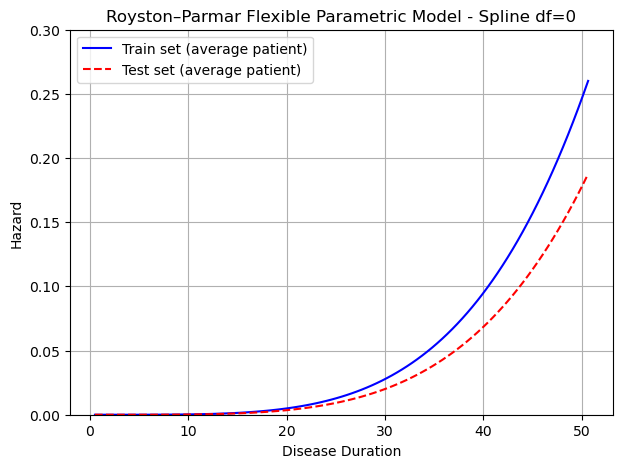

In [484]:
S_train = r_predict(fp_model, newdata=newdata_train, type="hazard")
S_test = r_predict(fp_model, newdata=newdata_test, type="hazard")

with localconverter(default_converter + pandas2ri.converter):
    py_S_train = np.array(S_train)
    py_S_test = np.array(S_test)

# Plot
plt.figure(figsize=(7,5))
plt.plot(times, py_S_train, label="Train set (average patient)", color='blue')
plt.plot(times, py_S_test, label="Test set (average patient)", color='red', linestyle='--')

plt.xlabel("Disease Duration")
plt.ylabel("Hazard")
plt.ylim(0, 0.3)
plt.title("Royston–Parmar Flexible Parametric Model - Spline df=0")
plt.legend()
plt.grid(True)
plt.show()

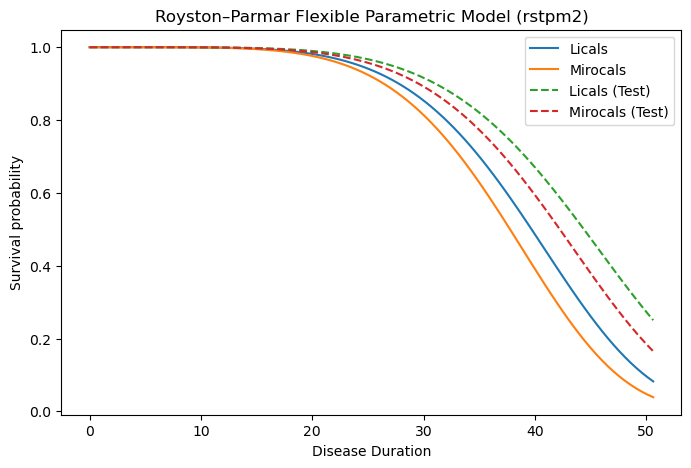

In [485]:
times = np.linspace(0, df1["Disease_Duration"].max(), 100)
times_r = FloatVector(times)

def make_newdata_category(df1, col):
    mean_Age = df1["Age"].mean()
    mean_TRICALS = df1["TRICALS"].mean()
    mean_Vital = df1["Vital_capacity"].mean()
    mean_Delay = df1["Diagnostic_Delay"].mean()

    mode_Onset = df1["Onset_Limb"].mode()[0]
    mode_Sex_onset = df1["Sex_onset"].mode()[0]
    mode_Expt = df1["Expt_mirocals"].mode()[0]
    mode_Study_Arm_Placebo = df1["Study_Arm_Placebo"].mode()[0]
    mean_Sex_Male = int(round(df1["Sex_Male"].mean()))

# ────────────────────────────────────────────────────
    # Choose the two Expt levels you want to compare
    level0 = df1[col].unique()[0]
    level1 = df1[col].unique()[1]

    with localconverter(default_converter + pandas2ri.converter):
    # Group 0
        newdata0 = DataFrame({
            "Age": FloatVector([mean_Age]*len(times)),
            "Onset_Limb": IntVector([mode_Onset]*len(times)),
            "TRICALS": FloatVector([mean_TRICALS]*len(times)),
            "Vital_capacity": FloatVector([mean_Vital]*len(times)),
            "Sex_Male": IntVector([mean_Sex_Male]*len(times)),
            "Study_Arm_Placebo": IntVector([mode_Study_Arm_Placebo]*len(times)),
            "Sex_onset": FloatVector([mode_Sex_onset]*len(times)),
            "Expt_mirocals": IntVector([level0]*len(times)),
            "Diagnostic_Delay": FloatVector([mean_Delay]*len(times)),
            "Disease_Duration": times_r
        })

    with localconverter(default_converter + pandas2ri.converter):
    # Group 1
        newdata1 = DataFrame({
            "Age": FloatVector([mean_Age]*len(times)),
            "Onset_Limb": IntVector([mode_Onset]*len(times)),
            "TRICALS": FloatVector([mean_TRICALS]*len(times)),
            "Vital_capacity": FloatVector([mean_Vital]*len(times)),
            "Sex_Male": IntVector([mean_Sex_Male]*len(times)),
            "Study_Arm_Placebo": IntVector([mode_Study_Arm_Placebo]*len(times)),
            "Sex_onset": FloatVector([mode_Sex_onset]*len(times)),
            "Expt_mirocals": IntVector([level1]*len(times)),
            "Diagnostic_Delay": FloatVector([mean_Delay]*len(times)),
            "Disease_Duration": times_r
        })
    return newdata0, newdata1
newdata_0_train, newdata_1_train = make_newdata_category(train_df, 'Expt_mirocals')
newdata_0_test, newdata_1_test = make_newdata_category(test_df, 'Expt_mirocals')


# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="surv")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="surv")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="surv")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)

#_______________________________________________________
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Licals")
plt.plot(times, py_S1_train, label=f"Mirocals")
plt.plot(times, py_S0_test, label=f"Licals (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Mirocals (Test)", linestyle='--')
plt.xlabel("Disease Duration")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


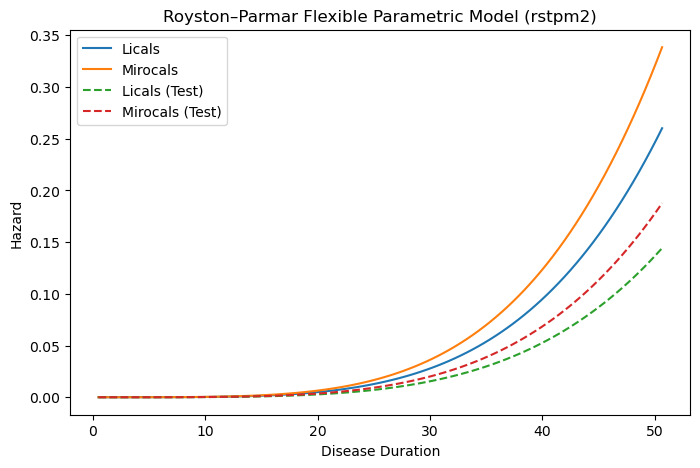

In [486]:
# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="hazard")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="hazard")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="hazard")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="hazard")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)

#_______________________________________________________
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Licals")
plt.plot(times, py_S1_train, label=f"Mirocals")
plt.plot(times, py_S0_test, label=f"Licals (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Mirocals (Test)", linestyle='--')
plt.xlabel("Disease Duration")
plt.ylabel("Hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


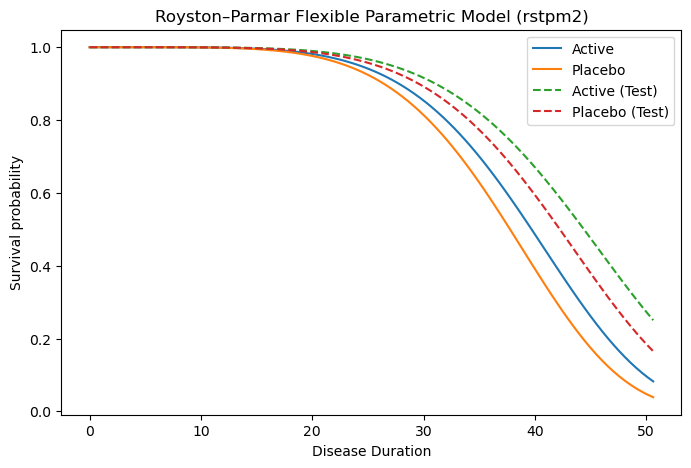

In [487]:
newdata_0_train, newdata_1_train = make_newdata_category(train_df, 'Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category(test_df, 'Study_Arm_Placebo')


# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="surv")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="surv")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="surv")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)

#_______________________________________________________
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Active")
plt.plot(times, py_S1_train, label=f"Placebo")
plt.plot(times, py_S0_test, label=f"Active (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Placebo (Test)", linestyle='--')
plt.xlabel("Disease Duration")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


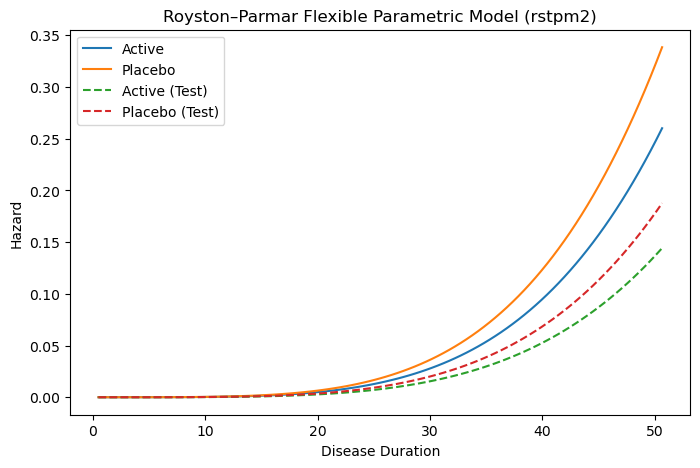

In [488]:
# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="hazard")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="hazard")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="hazard")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="hazard")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Active")
plt.plot(times, py_S1_train, label=f"Placebo")
plt.plot(times, py_S0_test, label=f"Active (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Placebo (Test)", linestyle='--')
plt.xlabel("Disease Duration")
plt.ylabel("Hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

In [489]:
# Perform likelihood ratio test between two models



## Prognostic Scores for Baseline Model (fit)

In [490]:
# prognostic score (linear predictor) with standard error
r_predict = r['predict']

train_df["prognostic_score"] = r_predict(fp_model, type = "link")
# test_df["prognostic_score"] = r_predict(fp_model, type = "link")

train_df.head(3)

,subject_id,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,European_Yes,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score
274,1-62532,1,miro,1,0.545148,-0.904108,1.264189,-1.207536,1,0,0,0,0.000000,0.545148,-0.492873,44.052967,0,-2.410315
291,1-63842,1,miro,0,0.157333,-0.587463,-0.514605,-1.436052,1,0,1,1,0.157333,0.157333,-0.092428,30.324967,0,-4.020875
103,P06011,0,lica,0,-0.164894,-0.196964,0.779864,0.564421,1,0,0,0,-0.000000,-0.164894,0.032478,32.207622,1,-1.505790


In [491]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

{'Low': 99, 'Medium': 99, 'High': 99}

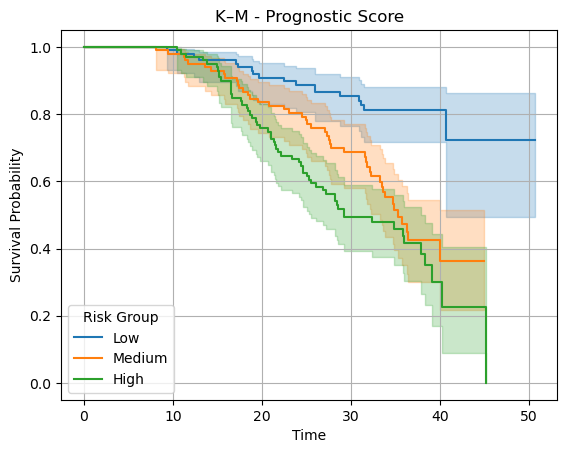

In [532]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [493]:
print(f"{train_df.Event.value_counts() / train_df.Event.value_counts().sum()}\n")
print(f"{train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()}\n")
print(f"{train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()}\n")
print(f"{train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()}\n")
print(f"{train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()}\n")

Event
0    0.592593
1    0.407407
Name: count, dtype: float64

Onset_Limb
1    0.804714
0    0.195286
Name: count, dtype: float64

Sex_Male
1    0.649832
0    0.350168
Name: count, dtype: float64

Study_Arm_Placebo
0    0.505051
1    0.494949
Name: count, dtype: float64

Expt_mirocals
1    0.579125
0    0.420875
Name: count, dtype: float64



In [494]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [495]:
ons, sex

(Onset_Limb
 1    0.804714
 0    0.195286
 Name: count, dtype: float64,
 Sex_Male
 1    0.649832
 0    0.350168
 Name: count, dtype: float64)

In [496]:
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls
0,P01001,0,107.0,Male,Limb,Placebo,European,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667
1,P01002,1,99.0,Female,Limb,Placebo,European,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582
2,P01003,0,102.0,Male,Limb,Active,European,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421


In [497]:
df1.columns

Index(['subject_id', 'Event', 'Disease_Duration', 'Expt_mirocals', 'Study_id',
       'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'European_Yes', 'Sex_Male', 'Sex_onset',
       'Age_Sex', 'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [498]:
df1.head(3)

,subject_id,Event,Disease_Duration,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,European_Yes,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0,32.600526,0,lica,1,-0.355001,-0.075830,0.363265,0.828667,1,0,1,1,-0.355001,-0.355001,0.026920
1,P01002,1,41.538765,0,lica,1,0.255274,-1.168542,1.103061,0.399582,1,0,0,0,0.000000,0.255274,-0.298299
2,P01003,0,34.571616,0,lica,0,-1.123785,-1.189109,0.616453,0.564421,1,0,1,1,-1.123785,-1.123785,1.336303


In [499]:
corr = train_df[['Age', 'Expt_mirocals','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

,Age,Expt_mirocals,Study_Arm_Placebo,Diagnostic_Delay,Vital_capacity,Sex_Male,Onset_Limb,TRICALS
Age,1.000000,-0.022954,0.046516,0.087078,0.076532,-0.103332,-0.031105,0.380008
Expt_mirocals,-0.022954,1.000000,-0.015432,-0.529909,0.159820,-0.125399,-0.041474,0.139871
Study_Arm_Placebo,0.046516,-0.015432,1.000000,0.120369,0.053132,-0.021533,0.045987,-0.048690
Diagnostic_Delay,0.087078,-0.529909,0.120369,1.000000,-0.022632,-0.001519,-0.020859,-0.437893
Vital_capacity,0.076532,0.159820,0.053132,-0.022632,1.000000,-0.155971,0.100920,-0.224311
Sex_Male,-0.103332,-0.125399,-0.021533,-0.001519,-0.155971,1.000000,0.172537,-0.104451
Onset_Limb,-0.031105,-0.041474,0.045987,-0.020859,0.100920,0.172537,1.000000,-0.167852
TRICALS,0.380008,0.139871,-0.048690,-0.437893,-0.224311,-0.104451,-0.167852,1.000000


In [500]:
# from scipy.stats import norm

# def gaussian_copula_samples(n, corr):
#     """
#     Draw correlated U(0,1) samples using a Gaussian copula.
#     corr = correlation matrix (p x p).
#     Returns: U (n x p) matrix of uniforms.
#     """
#     L = np.linalg.cholesky(corr)
#     Z = np.random.normal(size=(n, corr.shape[0]))
#     Z_corr = Z @ L.T
#     U = norm.cdf(Z_corr)
#     return U



# def simulate_cox_dataset(n,baseline='weibull',lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))
    elif baseline == 'weibull':
        # Weibull inverse CDF: T = (-log U)^(1/rho) / (lam*exp(lp))^(1/rho)
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df

IndentationError: unexpected indent (3426417855.py, line 18)

In [503]:
df = df_coef
df

,Variable,Estimate,Std. Error,z value,Pr(z),HR,CI_lower,CI_upper
0,Age,-0.451557,0.125915,-3.586199,3.355328e-04,-0.451557,-0.698351,-0.204763
1,Sex_Male,0.789987,0.387467,2.038853,4.146470e-02,0.789987,0.030553,1.549422
2,Onset_Limb,0.904501,0.320842,2.819149,4.815113e-03,0.904501,0.275651,1.533352
3,TRICALS,3.192837,0.236680,13.490123,1.788012e-41,3.192837,2.728945,3.656730
4,Sex_onset,-1.107842,0.440333,-2.515917,1.187233e-02,-1.107842,-1.970896,-0.244789
5,Expt_mirocals,-0.263275,0.232929,-1.130280,2.583584e-01,-0.263275,-0.719816,0.193266
6,Diagnostic_Delay,0.173148,0.135621,1.276712,2.017038e-01,0.173148,-0.092668,0.438965
7,Study_Arm_Placebo,0.202307,0.184363,1.097334,2.724955e-01,0.202307,-0.159043,0.563658


In [504]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [511]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Expt_mirocals', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [ ]:
def gaussian_copula_samples(n, corr):
    """
    Draw correlated U(0,1) samples using a Gaussian copula.
    corr = correlation matrix (p x p).
    Returns: U (n x p) matrix of uniforms.
    """
    L = np.linalg.cholesky(corr)
    Z = np.random.normal(size=(n, corr.shape[0]))
    Z_corr = Z @ L.T
    U = norm.cdf(Z_corr)
    return U


def estimate_baseline_cumhaz(original_df, time_col='time', event_col='event'):
    """
    Estimate baseline cumulative hazard from real data using Nelson–Aalen.
    """
    naf = NelsonAalenFitter()
    naf.fit(original_df[time_col], event_observed=original_df[event_col])

    H0 = naf.cumulative_hazard_.reset_index()
    H0.columns = ['time', 'cumhaz']
    return H0

H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

def sample_survival_times_from_empirical_baseline(U, H0_df, linpred):
    """
    Sample survival times using inverse cumulative hazard.

    U: uniform(0,1)
    H0_df: dataframe from estimate_baseline_cumhaz()
    linpred: linear predictor
    """

    # Effective cumulative hazard for each individual
    target = -np.log(U) / np.exp(linpred)

    # Interpolate to get survival times
    return np.interp(target, H0_df['cumhaz'], H0_df['time'])

def sample_survival_times_from_empirical_baseline(U, H0_df, linear_pred):
    """
    Inverse transform sampling using an empirical baseline cumulative hazard.
    """
    H0_t = H0_df["time"].values
    H0_vals = H0_df["cumhaz"].values

    v = -np.log(U) / np.exp(linear_pred)

    # Interpolate inverse of H0
    T = np.interp(v, H0_vals, H0_t, left=H0_t[0], right=H0_t[-1])
    return T

def simulate_cox_dataset_with_correlation(n,baseline='weibull', H0_df=None,lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == "empirical":
        if H0_df is None:
            raise ValueError("You must supply H0_df when using empirical baseline.")
        T = sample_survival_times_from_empirical_baseline(U_time, H0_df, linear_pred)

    elif baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))

    elif baseline == 'weibull':
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df



In [513]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

Event
0    0.592593
1    0.407407
Name: count, dtype: float64

In [ ]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset_with_correlation(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [515]:
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex_Male,Onset_Limb,Expt_mirocals,Study_Arm_Placebo
0,50.636005,1,50.636005,-3.007558,0.597148,-1.441860,1.340995,1,1,1,1
1,4.806857,1,4.806857,6.015376,0.634802,1.368782,0.201735,1,1,0,1
2,19.585865,1,19.585865,-0.147309,-0.355778,-0.645185,0.684305,1,1,1,1


In [516]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic_Delay,Sex_Male,Onset_Limb,Expt_mirocals,Study_Arm_Placebo,Sex_onset
0,50.636005,1,50.636005,-3.007558,0.597148,-1.441860,1.340995,1,1,1,1,1
1,4.806857,1,4.806857,6.015376,0.634802,1.368782,0.201735,1,1,0,1,1
2,19.585865,1,19.585865,-0.147309,-0.355778,-0.645185,0.684305,1,1,1,1,1


In [517]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

event
0    187
1    110
Name: count, dtype: int64

In [518]:
train_df.head(3)

,subject_id,Expt_mirocals,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,European_Yes,Sex_Male,Sex_onset,Age_Sex,Age_onset,Age_TRICALS,Disease_Duration,Event,prognostic_score,risk_group
274,1-62532,1,miro,1,0.545148,-0.904108,1.264189,-1.207536,1,0,0,0,0.000000,0.545148,-0.492873,44.052967,0,-2.410315,Medium
291,1-63842,1,miro,0,0.157333,-0.587463,-0.514605,-1.436052,1,0,1,1,0.157333,0.157333,-0.092428,30.324967,0,-4.020875,Low
103,P06011,0,lica,0,-0.164894,-0.196964,0.779864,0.564421,1,0,0,0,-0.000000,-0.164894,0.032478,32.207622,1,-1.505790,Medium


In [519]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

Event
0    176
1    121
Name: count, dtype: int64

In [520]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

Onset_Limb
1    0.804714
0    0.195286
Name: count, dtype: float64 Sex_Male
1    0.649832
0    0.350168
Name: count, dtype: float64 Sex_onset
1    0.555556
0    0.444444
Name: count, dtype: float64

---- Simulated data ----
Onset_Limb
1    0.794613
0    0.205387
Name: count, dtype: float64 Sex_Male
1    0.670034
0    0.329966
Name: count, dtype: float64 Sex_onset
1    0.555556
0    0.444444
Name: count, dtype: float64


In [521]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [522]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Sex_onset + Expt_mirocals + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
print(ro.r.summary(fp_model1))

Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(true_survival_time, event == 1) ~ Age + Study_Arm_Placebo + 
    Onset_Limb + TRICALS + Sex_Male + Sex_onset + Expt_mirocals + 
    Diagnostic_Delay, data = list(time = c(50.6360052562418, 
4.80685682877511, 19.5858649308334, 20.3360958799502, 3.56972759625349, 
13.5972172571036, 3.09404680531267, 18.3395871637499, 14.2253571364315, 
6.62942804149897, 11.3535514322303, 8.38028986007568, 4.29615014632038, 
7.7514712538024, 7.83759840595318, 2.08441116612788, 5.37017830254742, 
13.9651085938112, 9.39800832781211, 8.85343447846284, 11.1231902388476, 
7.37651459285822, 8.885207904409, 7.53194775651355, 13.348927941123, 
11.8679980895395, 11.1295206642215, 28.3263190620555, 32.0090398791263, 
17.686

In [523]:
# Get coefficients directly
summary1 = ro.r.summary(fp_model1)

# Try using slotNames to see what's available
# print("Available slots:", ro.r.slotNames(summary))

# Extract using the correct slot name (usually 'coef' or 'coefficients')
coefficients1 = summary1.slots['coef']

# Convert to pandas DataFrame
df_coef1 = pd.DataFrame(
    np.array(coefficients1),
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
    index=list(coefficients1.rownames)
)

df_coef1 = df_coef1.iloc[1: -1]
df_coef1 = df_coef1.reset_index().rename(columns={"index": "Variable"})


print(df_coef1)

            Variable  Estimate  Std. Error    z value         Pr(z)
0                Age -0.320233    0.115329  -2.776699  5.491400e-03
1  Study_Arm_Placebo  0.338989    0.195181   1.736797  8.242306e-02
2         Onset_Limb  0.467276    0.491737   0.950255  3.419828e-01
3            TRICALS  2.540360    0.205631  12.353980  4.636013e-35
4           Sex_Male  0.468043    0.549595   0.851615  3.944280e-01
5          Sex_onset -0.049733    0.595542  -0.083508  9.334472e-01
6      Expt_mirocals -0.367888    0.224800  -1.636514  1.017320e-01
7   Diagnostic_Delay  0.101772    0.120039   0.847824  3.965358e-01


In [524]:
df_coef

,Variable,Estimate,Std. Error,z value,Pr(z),HR,CI_lower,CI_upper
0,Age,-0.451557,0.125915,-3.586199,3.355328e-04,-0.451557,-0.698351,-0.204763
1,Sex_Male,0.789987,0.387467,2.038853,4.146470e-02,0.789987,0.030553,1.549422
2,Onset_Limb,0.904501,0.320842,2.819149,4.815113e-03,0.904501,0.275651,1.533352
3,TRICALS,3.192837,0.236680,13.490123,1.788012e-41,3.192837,2.728945,3.656730
4,Sex_onset,-1.107842,0.440333,-2.515917,1.187233e-02,-1.107842,-1.970896,-0.244789
5,Expt_mirocals,-0.263275,0.232929,-1.130280,2.583584e-01,-0.263275,-0.719816,0.193266
6,Diagnostic_Delay,0.173148,0.135621,1.276712,2.017038e-01,0.173148,-0.092668,0.438965
7,Study_Arm_Placebo,0.202307,0.184363,1.097334,2.724955e-01,0.202307,-0.159043,0.563658


In [526]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs

,Variable,Estimate_real,Std. Error_real,z value_real,Pr(z)_real,HR,CI_lower,CI_upper,Estimate_simulated,Std. Error_simulated,z value_simulated,Pr(z)_simulated
0,Age,-0.451557,0.125915,-3.586199,3.355328e-04,-0.451557,-0.698351,-0.204763,-0.320233,0.115329,-2.776699,5.491400e-03
1,Sex_Male,0.789987,0.387467,2.038853,4.146470e-02,0.789987,0.030553,1.549422,0.468043,0.549595,0.851615,3.944280e-01
2,Onset_Limb,0.904501,0.320842,2.819149,4.815113e-03,0.904501,0.275651,1.533352,0.467276,0.491737,0.950255,3.419828e-01
3,TRICALS,3.192837,0.236680,13.490123,1.788012e-41,3.192837,2.728945,3.656730,2.540360,0.205631,12.353980,4.636013e-35
4,Sex_onset,-1.107842,0.440333,-2.515917,1.187233e-02,-1.107842,-1.970896,-0.244789,-0.049733,0.595542,-0.083508,9.334472e-01
5,Expt_mirocals,-0.263275,0.232929,-1.130280,2.583584e-01,-0.263275,-0.719816,0.193266,-0.367888,0.224800,-1.636514,1.017320e-01
6,Diagnostic_Delay,0.173148,0.135621,1.276712,2.017038e-01,0.173148,-0.092668,0.438965,0.101772,0.120039,0.847824,3.965358e-01
7,Study_Arm_Placebo,0.202307,0.184363,1.097334,2.724955e-01,0.202307,-0.159043,0.563658,0.338989,0.195181,1.736797,8.242306e-02


In [527]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

,Variable,Estimate_real,Estimate_simulated
0,Age,-0.451557,-0.320233
1,Sex_Male,0.789987,0.468043
2,Onset_Limb,0.904501,0.467276
3,TRICALS,3.192837,2.540360
4,Sex_onset,-1.107842,-0.049733
5,Expt_mirocals,-0.263275,-0.367888
6,Diagnostic_Delay,0.173148,0.101772
7,Study_Arm_Placebo,0.202307,0.338989


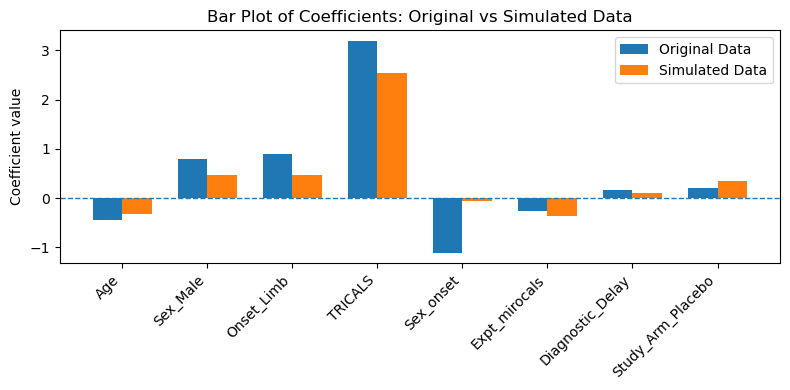

In [528]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


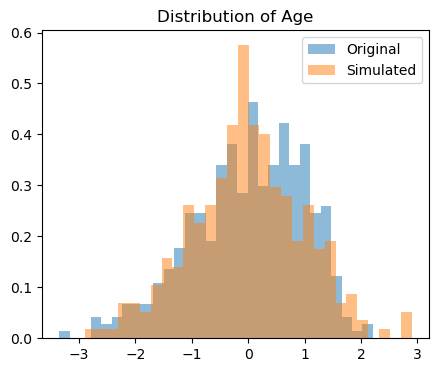

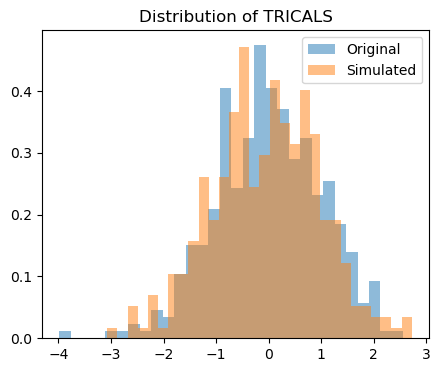

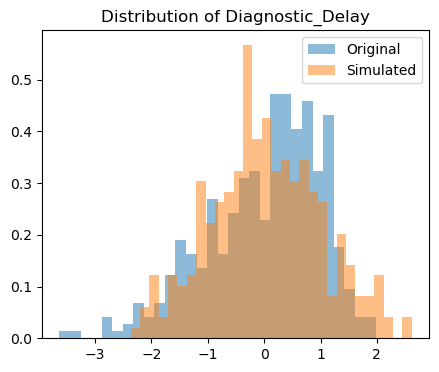

In [529]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(df1[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

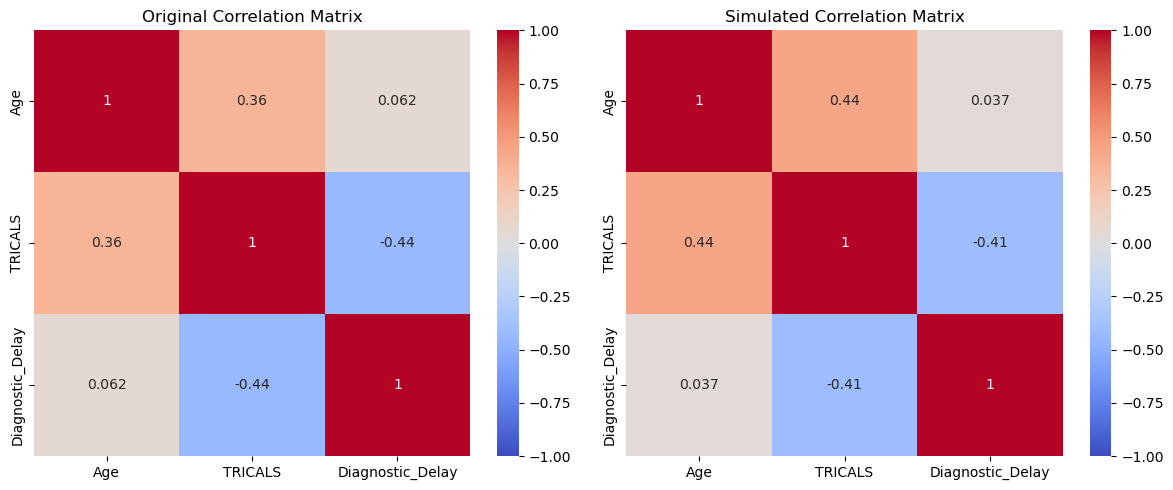

In [530]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(df1[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

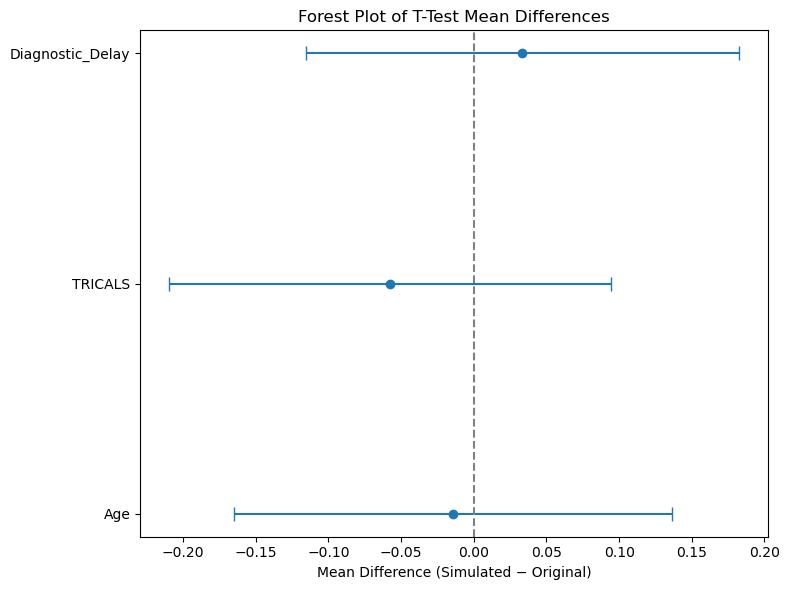

In [531]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = df1[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model